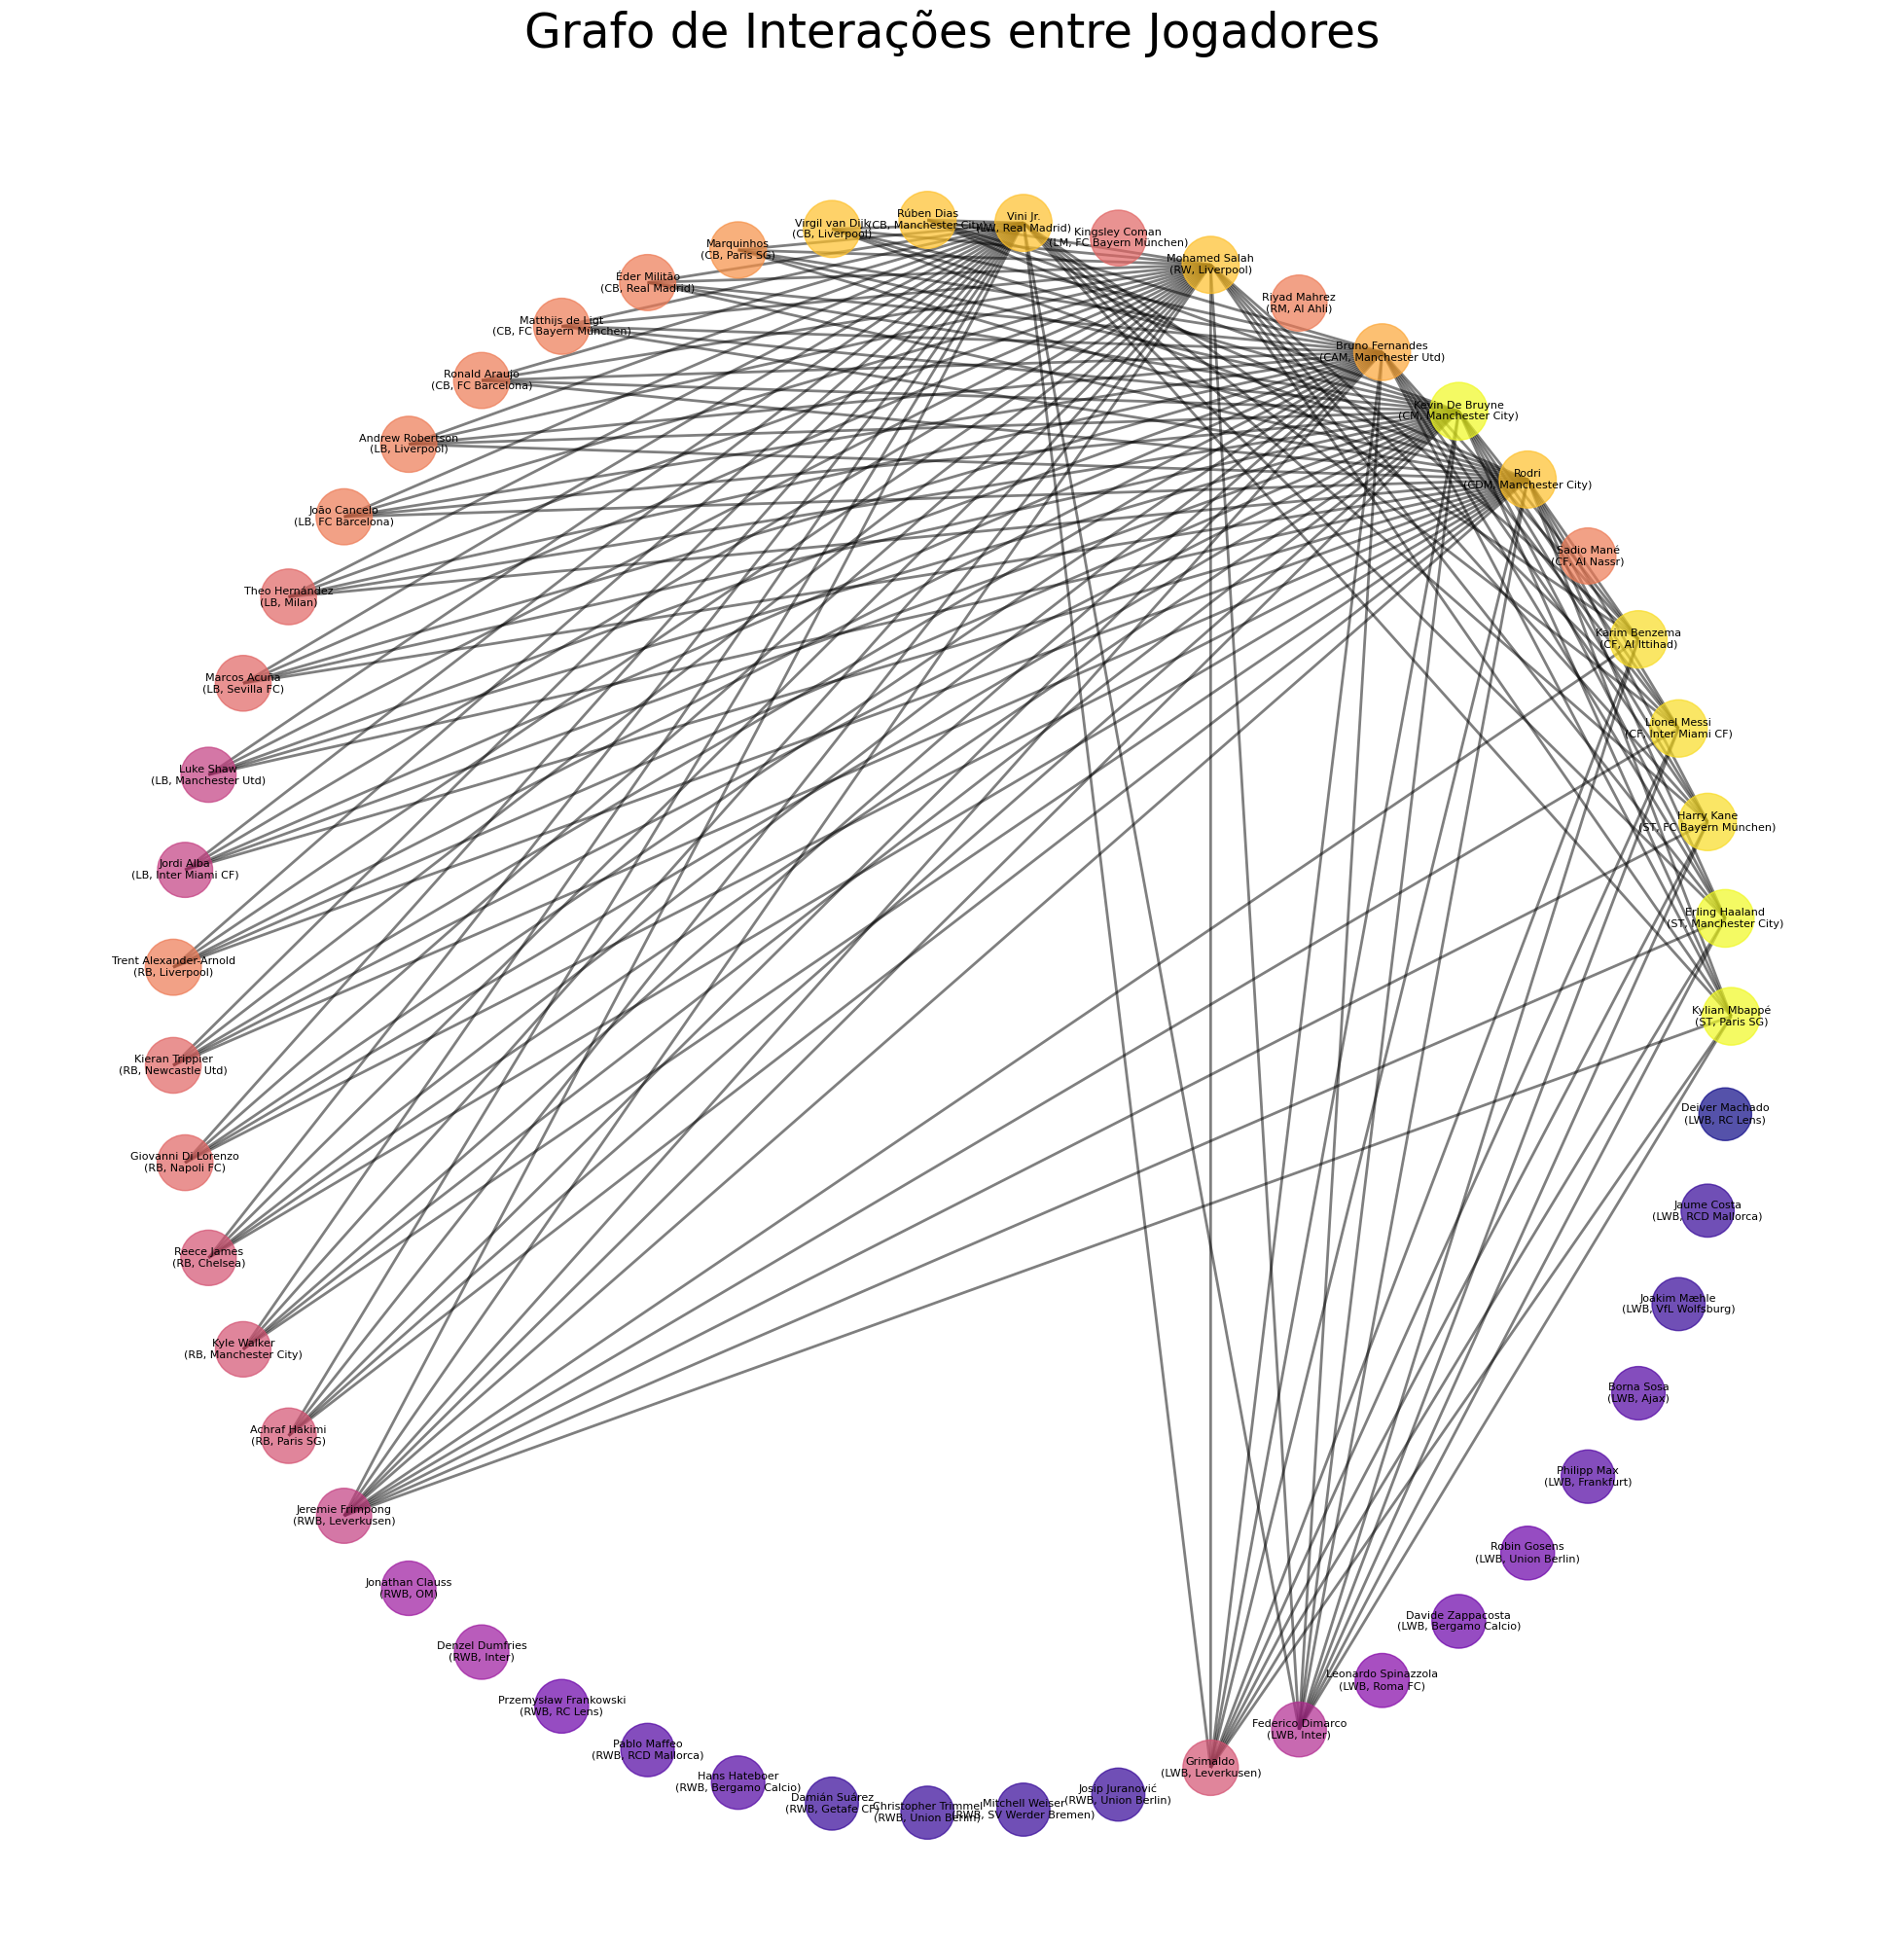

O grafo tem 145 arestas.


In [5]:
# Importando as bibliotecas necessárias
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Carregar o arquivo CSV filtrado em um DataFrame
filtered_csv_path = 'top_players_filtered.csv'
players_data = pd.read_csv(filtered_csv_path)

# Criar um grafo vazio
G = nx.Graph()

# Adicionar cada jogador como um nó no grafo
for index, row in players_data.iterrows():
    G.add_node(row['Name'], position=row['Position'], overall=row['Overall'], club=row['Club'])

# Categorias e seus respectivos thresholds
thresholds = {
    'Atacantes': 88,
    'Meias': 88,
    'Zagueiros': 82,
    'Laterais': 82
}

# Política de conexões baseada na lógica tática
connection_policy = {
    'Atacantes': ['Meias', 'Laterais'],  # Atacantes frequentemente recebem passes dos meias e laterais
    'Meias': ['Atacantes', 'Zagueiros', 'Laterais'],  # Meias conectam o jogo entre a defesa e o ataque, e colaboram com os laterais
    'Zagueiros': ['Meias'],  # Zagueiros normalmente passam a bola para os meias
    'Laterais': ['Meias', 'Atacantes']  # Laterais apoiam o ataque e frequentemente interagem com meias e atacantes
}

# Mapeamento das posições específicas para suas categorias
position_to_category = {
    'ST': 'Atacantes', 'CF': 'Atacantes', 'RF': 'Atacantes', 'RS': 'Atacantes', 'LF': 'Atacantes', 'LS': 'Atacantes',
    'CDM': 'Meias', 'CM': 'Meias', 'CAM': 'Meias', 'ROM': 'Meias', 'RM': 'Meias', 'RWM': 'Meias', 'RW': 'Meias', 
    'LOM': 'Meias', 'LM': 'Meias', 'LWM': 'Meias', 'LW': 'Meias',
    'CB': 'Zagueiros', 'LB': 'Zagueiros', 'RB': 'Zagueiros',
    'RWB': 'Laterais', 'LWB': 'Laterais'
}

# Adicionando arestas com base na política de conexões e thresholds
for player1 in G.nodes():
    for player2 in G.nodes():
        if player1 != player2:  # Evita autoconexão
            player1_category = position_to_category[G.nodes[player1]['position']]
            player2_category = position_to_category[G.nodes[player2]['position']]
            if player2_category in connection_policy[player1_category]:  # Verifica compatibilidade de posição
                if G.nodes[player1]['overall'] >= thresholds[player1_category] and G.nodes[player2]['overall'] >= thresholds[player2_category]:  # Verifica thresholds de 'Overall'
                    G.add_edge(player1, player2)  # Cria a aresta se ambas condições forem atendidas

# Configuração para a visualização do grafo
plt.figure(figsize=(25, 25))
pos = nx.circular_layout(G)  # ou nx.spring_layout(G)

# Desenhando os nós e arestas
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='black')
node_size = [G.nodes[node]['overall'] * 20 for node in G]
node_color = [G.nodes[node]['overall'] for node in G]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=plt.cm.plasma, alpha=0.7)

# Desenhando os rótulos (nome e clube)
labels = {node: f"{node}\n({G.nodes[node]['position']}, {G.nodes[node]['club']})" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', verticalalignment='center')

plt.title("Grafo de Interações entre Jogadores", size=35)
plt.axis('off')
plt.show()

# Verifique se as arestas foram criadas
print(f"O grafo tem {G.number_of_edges()} arestas.")

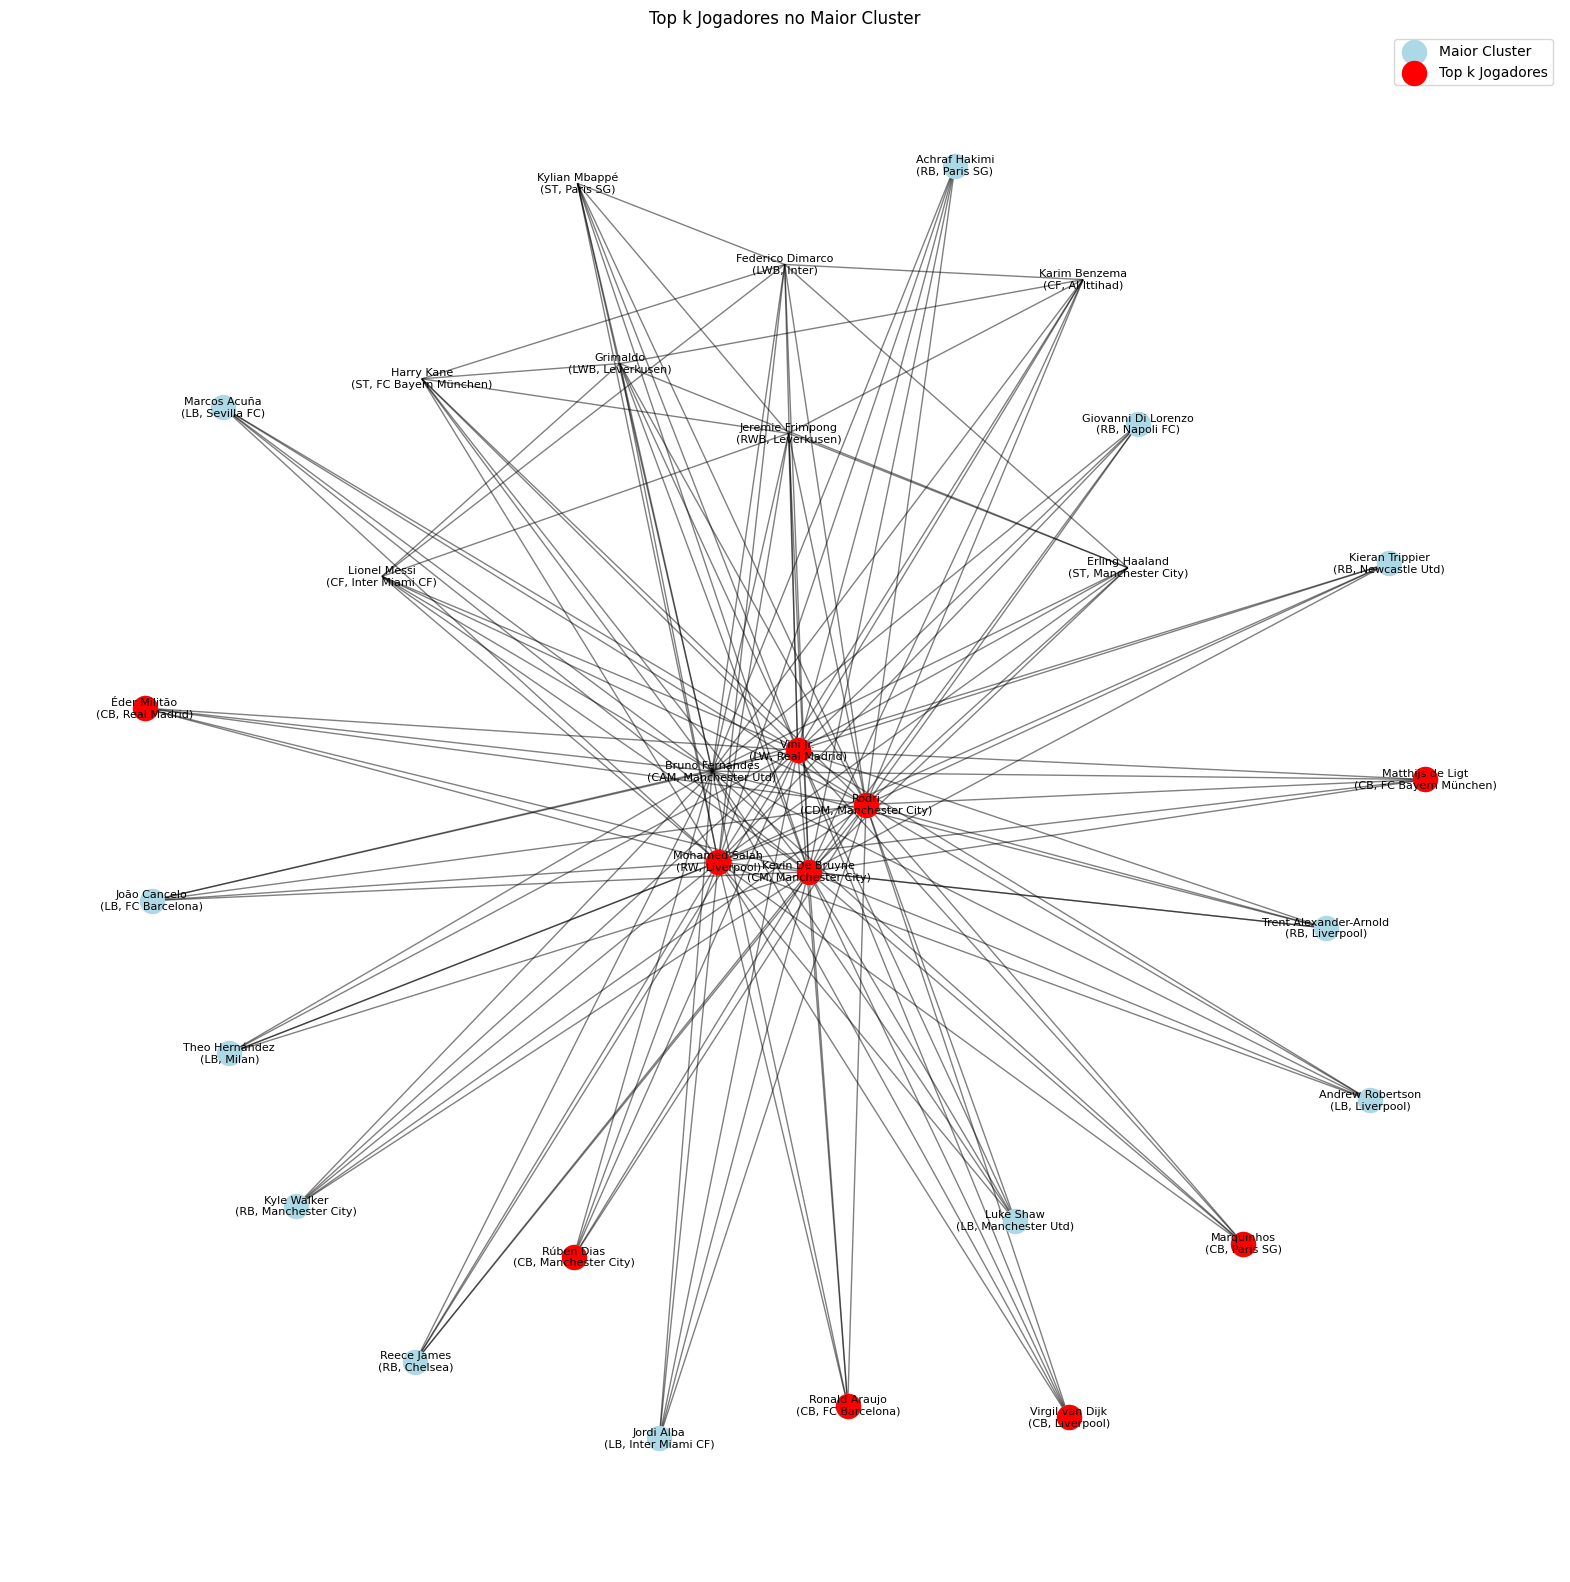

Clubes dos Top k Jogadores: ['Manchester City', 'Manchester City', 'Liverpool', 'Real Madrid', 'Manchester City', 'Liverpool', 'Paris SG', 'Real Madrid', 'FC Bayern München', 'FC Barcelona']


In [6]:
from networkx.algorithms.community import greedy_modularity_communities

# Aplicando o algoritmo greedy_modularity_communities para detectar comunidades
communities = greedy_modularity_communities(G, weight='weight')

# Identificando o maior cluster
largest_community = max(communities, key=len)

# Calculando a centralidade de grau dos jogadores no maior cluster
degree_centrality = nx.degree_centrality(G)
largest_community_centrality = {node: centrality for node, centrality in degree_centrality.items() if node in largest_community}

# Selecionando os 'top k' jogadores mais conectados
k = 10  # Define o número de jogadores top para análise
top_k_players = sorted(largest_community_centrality, key=largest_community_centrality.get, reverse=True)[:k]

# Visualização do maior cluster com destaque para os 'top k' jogadores
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, seed=42)  # Posicionamento dos nós
nx.draw_networkx_nodes(G, pos, nodelist=largest_community, node_color='lightblue', label='Maior Cluster')
nx.draw_networkx_nodes(G, pos, nodelist=top_k_players, node_color='red', label='Top k Jogadores')
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Desenhando os rótulos dos nós com o nome, posição e clube
labels = {node: f"{node}\n({G.nodes[node]['position']}, {G.nodes[node]['club']})" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', verticalalignment='center')

plt.legend()
plt.title("Top k Jogadores no Maior Cluster")
plt.axis('off')
plt.show()

# Análise das afiliações de equipe dos 'top k' jogadores
top_k_clubs = [G.nodes[player]['club'] for player in top_k_players]
print("Clubes dos Top k Jogadores:", top_k_clubs)